In [403]:
import pandas as pd
import numpy as np
import scipy.stats
import pickle

from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

from collections import Counter

from scipy.stats import entropy


# plotting
import matplotlib
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3,
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(6, 5)})

import sys
sys.path.append("../../../data/")

In [395]:
filepath = "../../BCCASII/Household/top_features_handpicked.xlsx"

# load data file and variable types
DATA = pd.read_excel(filepath)

In [396]:
def weighted_hamming(X):
    # compute number of categories per feature
    pi_k = np.zeros(len(X.columns))
    for i, col in enumerate(X.columns):
        pi_k[i] = len(X[col].unique())
    pi_k = 1/pi_k

    X = np.array(X)

    H = np.zeros((len(X), len(X)))
    for i in range(len(X)):
        for j in range(i+1, len(X)):
            hamming = np.sum(np.array(X[i] != X[j]) * pi_k)
            H[i][j] = hamming
            H[j][i] = hamming
            
    return H

In [397]:
# code is adapted from:
# https://github.com/arashbehboodi/DiffusionMap


def diffusionmap(distance_mat, n, eps, t, n_eigen, alpha=1/2):
    """
    distance_mat: distance matrix
    t: t indicates the number of iterations.
    n_eigen: indicates the target dimension for dimensionality reduction
    eps: is the parameter of Guassian kernel that is used.
    """    
    # Kernel function for weight matrx: Gaussian Kernel
    # Constructing the weight matrix
    W = np.exp(-distance_mat/eps)
    
    # Degree matrix
    Deg = W@np.ones((n, 1))
    D = np.diag(Deg.reshape(n,))
    
    # Transition matrix
    M = np.linalg.inv(D)@W
    
    # Constructing the matrix S - obtaining diffusion vectors
    S = D**(alpha)@M@np.linalg.inv(D)**(alpha)
    
    # Spectral decomposition
    eigvalCov, eigvecCov = np.linalg.eig(S)
    idx = eigvalCov.argsort()[::-1]
    eigvalCov = eigvalCov[idx]
    eigvecCov = eigvecCov[:, idx]
    
    # Diffusion Map
    phiD = np.linalg.inv(D)**(alpha)@eigvecCov
    lambdaD = eigvalCov**t
    
    # Final Matrix with columns as the vectors
    DiffM = np.diag(lambdaD)@phiD.T
    Difftruncated = DiffM[1:n_eigen+1, :]
    return Difftruncated.T

___

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


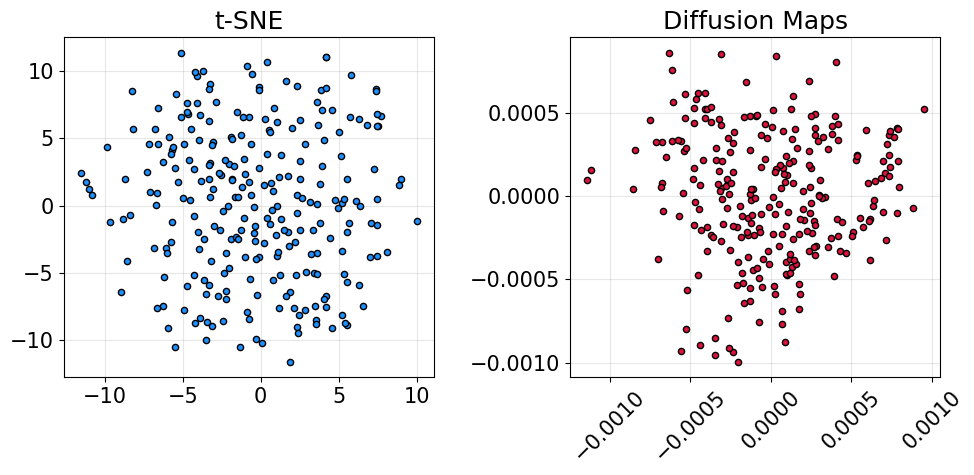

In [379]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

no_empty = []
for index, row in DATA.iterrows():
    if -1 in list(row):
        continue
    else:
        no_empty.append(row)

DATA = pd.concat(no_empty, axis=1).T
        
X_one_hot = pd.DataFrame(OneHotEncoder(sparse=False, drop="if_binary").fit_transform(DATA))


ham = weighted_hamming(X_one_hot)
tsne_coords = TSNE(metric="precomputed").fit_transform(ham)
axs[0].scatter(tsne_coords[:,0], tsne_coords[:,1], color="dodgerblue", edgecolor="k", s=20)
axs[0].set_title("t-SNE")

D = cosine_distances(X_one_hot)
dm_coords = diffusionmap(D, len(DATA), 2, 0.5, 2)
axs[1].scatter(dm_coords[:,0], dm_coords[:,1], color="crimson", edgecolor="k", s=20)
axs[1].set_title("Diffusion Maps")
axs[1].tick_params(axis='x', labelrotation = 45)

plt.tight_layout()
plt.show()

In [398]:
no_empty = []
for index, row in DATA.iterrows():
    if -1 in list(row):
        continue
    else:
        no_empty.append(row)

DATA = pd.concat(no_empty, axis=1).T

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


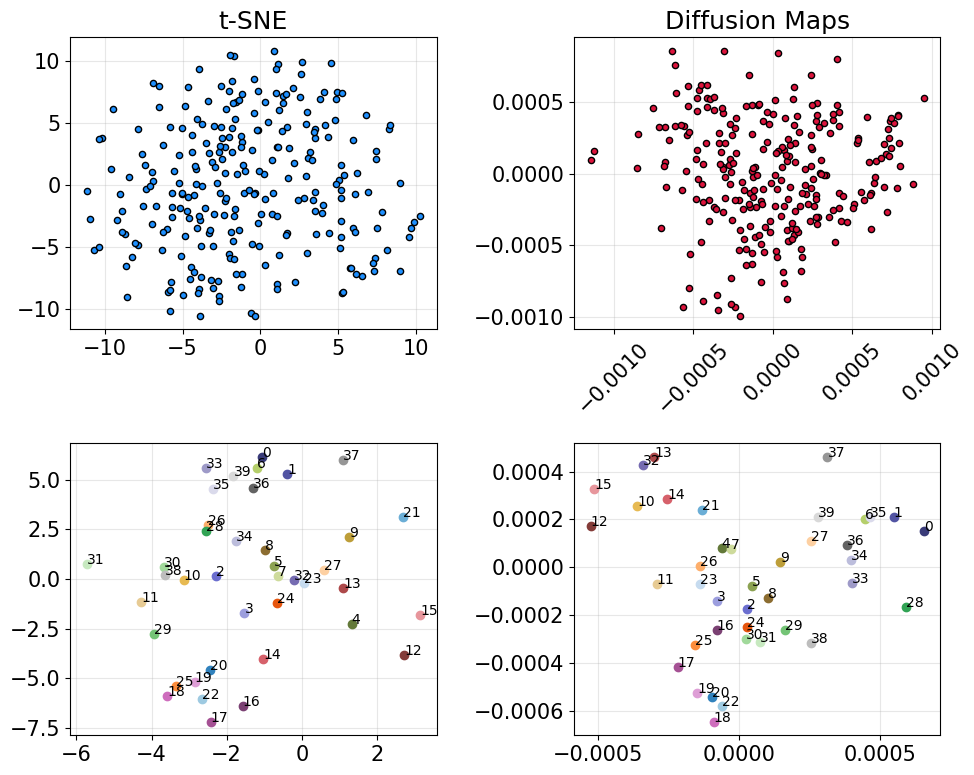

In [431]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
        
X_one_hot = pd.DataFrame(OneHotEncoder(sparse=False, drop="if_binary").fit_transform(DATA))


ham = weighted_hamming(X_one_hot)
tsne_coords = TSNE(metric="precomputed").fit_transform(ham)
axs[0][0].scatter(tsne_coords[:,0], tsne_coords[:,1], color="dodgerblue", edgecolor="k", s=20)
axs[0][0].set_title("t-SNE")

communities_tsne = {i:[] for i in range(40)}
for i, row in enumerate(tsne_coords):
    communities_tsne[DATA.iloc[i]["community_code"]].append(row)

for c in communities_tsne:
    combined = np.row_stack(communities_tsne[c])
    combined = np.mean(combined, axis=0)
    if c < 20:
        axs[1][0].scatter(combined[0], combined[1], color=cm.tab20b(c%20))
    else:
        axs[1][0].scatter(combined[0], combined[1], color=cm.tab20c(c%20))
        
    axs[1][0].annotate(c, (combined[0], combined[1]), fontsize=10)
        
        
D = cosine_distances(X_one_hot)
dm_coords = diffusionmap(D, len(DATA), 2, 0.5, 2)
axs[0][1].scatter(dm_coords[:,0], dm_coords[:,1], color="crimson", edgecolor="k", s=20)
axs[0][1].set_title("Diffusion Maps")
axs[0][1].tick_params(axis='x', labelrotation = 45)

communities_dm = {i:[] for i in range(40)}
for i, row in enumerate(dm_coords):
    communities_dm[DATA.iloc[i]["community_code"]].append(row)
    
for c in communities_dm:
    combined = np.row_stack(communities_dm[c])
    combined = np.mean(combined, axis=0)    
    if c < 20:
        axs[1][1].scatter(combined[0], combined[1], color=cm.tab20b(c%20))
    else:
        axs[1][1].scatter(combined[0], combined[1], color=cm.tab20c(c%20))
        
    axs[1][1].annotate(c, (combined[0], combined[1]), fontsize=10)

plt.tight_layout()
plt.savefig("tsne_dm_bccas.pdf", bbox_inches="tight")
plt.show()

In [432]:
communities_dm = {k: np.mean(np.row_stack(v), axis=0) for k,v in communities_dm.items()}

In [433]:
communities_tsne = {k: np.mean(np.row_stack(v), axis=0) for k,v in communities_tsne.items()}

In [444]:
dm_stacked = np.row_stack(list(communities_dm.values()))
dm_Dist = euclidean_distances(dm_stacked)
dm_dist_vals = []
for i in range(dm_Dist.shape[0]):
    for j in range(i+1, dm_Dist.shape[0]):
        dm_dist_vals.append(dm_Dist[i][j])

In [445]:
tsne_stacked = np.row_stack(list(communities_tsne.values()))
tsne_Dist = euclidean_distances(tsne_stacked)
tsne_dist_vals = []
for i in range(tsne_Dist.shape[0]):
    for j in range(i+1, tsne_Dist.shape[0]):
        tsne_dist_vals.append(tsne_Dist[i][j])

(0.5691122553876133, 3.77590434199743e-68)
(0.5141402000514871, 7.604459173463062e-54)
(0.3178715903628152, 8.990849101017e-20)


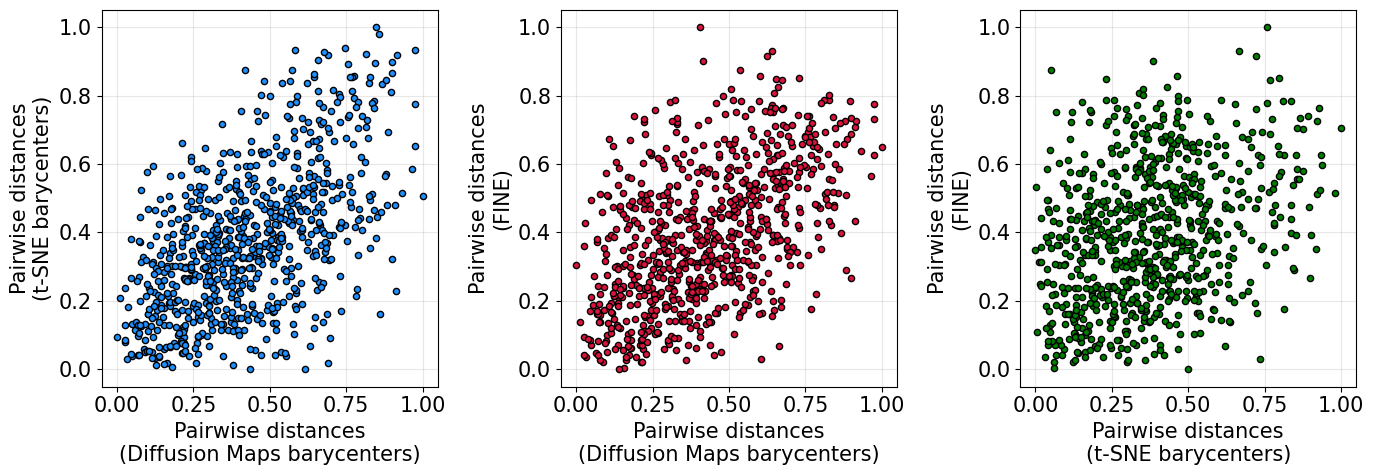

In [481]:
fig, axs = plt.subplots(1, 3, figsize=(14,5))

colors = ["dodgerblue", "crimson", "green"]

xlabels = ["Pairwise distances\n(Diffusion Maps barycenters)",
           "Pairwise distances\n(Diffusion Maps barycenters)",
           "Pairwise distances\n(t-SNE barycenters)"]

ylabels = ["Pairwise distances\n(t-SNE barycenters)",
           "Pairwise distances\n(FINE)",
           "Pairwise distances\n(FINE)"]


for i, pair in enumerate([(dm_dist_vals, tsne_dist_vals), 
                          (dm_dist_vals, handpicked_dist_vals), 
                          (tsne_dist_vals, handpicked_dist_vals)]):
    
    x = (pair[0] - min(pair[0])) / (max(pair[0]) - min(pair[0]))
    y = (pair[1] - min(pair[1])) / (max(pair[1]) - min(pair[1]))

    axs[i].scatter(x, y, color=colors[i], edgecolor="k", s=20)
    
    axs[i].set_xlabel(xlabels[i])
    axs[i].set_ylabel(ylabels[i])
    
    print(pearsonr(x, y))
    

fig.tight_layout()
plt.savefig("pairwise_correlations.pdf", bbox_inches="tight")
plt.show()

In [455]:
handpicked_Dist = euclidean_distances(handpicked)
handpicked_dist_vals = []
for i in range(handpicked_Dist.shape[0]):
    for j in range(i+1, handpicked_Dist.shape[0]):
        handpicked_dist_vals.append(handpicked_Dist[i][j])

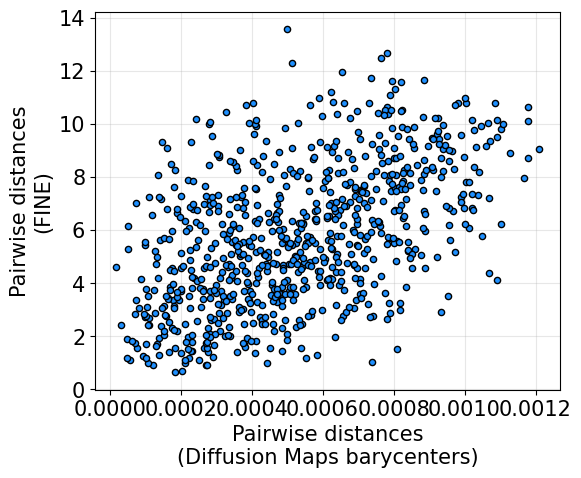

In [456]:
plt.scatter(dm_dist_vals, handpicked_dist_vals, color="dodgerblue", edgecolor="k", s=20)
plt.xlabel("Pairwise distances\n(Diffusion Maps barycenters)")
plt.ylabel("Pairwise distances\n(FINE)")
plt.show()

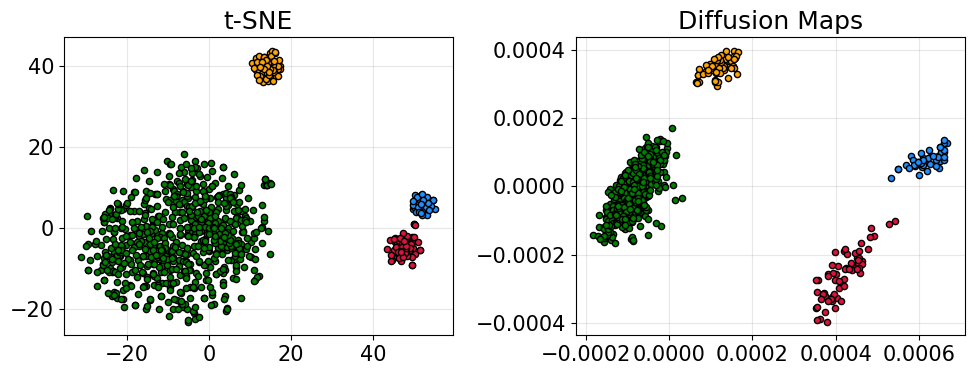

In [114]:
tsne_labels = []
for i, row in enumerate(tsne_coords):
    if row[1] < -30:
        tsne_labels.append(0)
    elif row[0] > -20:
        tsne_labels.append(1)
    elif row[1] > -2:
        tsne_labels.append(2)
    else:
        tsne_labels.append(3)


fig, axs = plt.subplots(1, 2, figsize=(10,4))

colors = ["orange", "green", "crimson", "dodgerblue"]
titles = ["t-SNE", "Diffusion Maps"]

for j, coords in enumerate([-tsne_coords, dm_coords]):
    for i, row in enumerate(coords):
        axs[j].scatter(row[0], row[1], color=colors[tsne_labels[i]], edgecolor='k', s=20)
    axs[j].set_title(titles[j])
    
fig.tight_layout()
plt.savefig("tsne_dm_bccas.pdf", bbox_inches="tight")

plt.show()

In [118]:
grouped_rows = {i:[] for i in range(4)}
for i in range(len(tsne_labels)):
    grouped_rows[tsne_labels[i]].append(DATA.iloc[i])

In [155]:
results = []

for feature in DATA.columns:
    if feature == "community_code":
        continue

    kl_vals = []
    for i in range(4):
        i_vals = [x[feature] for x in grouped_rows[i] if x[feature] != -1]
        i_dict = dict(Counter(i_vals))
        i_dict = {k:v/sum(i_dict.values()) for k,v in i_dict.items()}
        for j in range(i+1, 4):
            j_vals = [x[feature] for x in grouped_rows[j] if x[feature] != -1]    
            j_dict = dict(Counter(j_vals))
            j_dict = {k:v/sum(j_dict.values()) for k,v in j_dict.items()}
            
        for k in i_dict:
            if k not in j_dict:
                j_dict[k] = 0
        for k in j_dict:
            if k not in i_dict:
                i_dict[k] = 0
                
        keys = sorted(i_dict.keys())
        
        kl_vals.append(entropy([i_dict[k] for k in keys], [j_dict[k] for k in keys]))
        
    kl_vals = [v for v in kl_vals if v != np.inf and not np.isnan(v)]
    
    results.append((feature, np.mean(kl_vals)))

In [156]:
sorted(results, key = lambda x: x[1], reverse=True)

[('change_production_methods', 0.1379479032396842),
 ('job_farming', 0.11503375640350383),
 ('constraint_7_total_severity', 0.09501820164281735),
 ('change_fertilizer', 0.09221957369638856),
 ('change_land', 0.08361747016451498),
 ('job_wage_labor', 0.08230334804201879),
 ('r3_04_2', 0.07579378915448101),
 ('constraint_1_total_severity', 0.06791169089372462),
 ('total_expenditures', 0.06236582771287067),
 ('r3_07_2', 0.06071240700563496),
 ('constraint_3_total_severity', 0.0586504845941374),
 ('r6_06_2', 0.05740396756190395),
 ('r6_08_2', 0.05082651743191567),
 ('r6_07_2', 0.04076505075018093),
 ('r3_05_2', 0.03925886069335505),
 ('calamity_3_loss', 0.03840684796770926),
 ('change_off_farm_employment', 0.03666931787556934),
 ('change_planting_dates', 0.03359635231358597),
 ('r3_02_2', 0.025980683835616424),
 ('change_livestock_poultry', 0.02400546882553876),
 ('constraint_6_total_severity', 0.01753233360275876),
 ('calamity_10_loss', 0.016065034386040348),
 ('constraint_4_total_severit

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


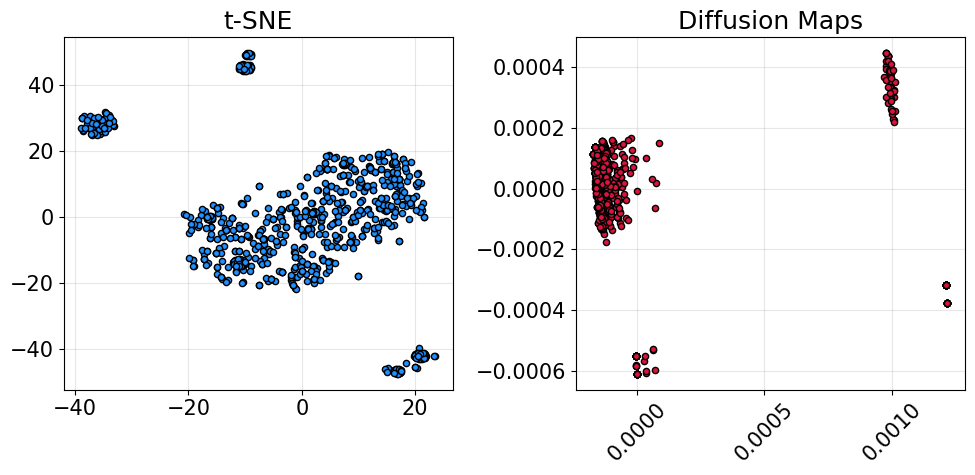

In [322]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))


feats = [x[0] for x in sorted(results, key = lambda x: x[1], reverse=True) if x[1] == 0]
feats = [f for f in feats if "calamity" not in f and "job" not in f and "r6_" not in f]
feats = [f for f in feats if "shocks" not in f and "constraint" not in f]
feats = [f for f in feats if "average_" not in f]

# feats = [f for f in feats if f != "r2_15_2" and f != "r2_23" and f != "r2_18"]
# feats = [f for f in feats if f != "r3_02_1" and f!= "r2_17" and f != "r2_22"]
# feats = [f for f in feats if f != "r2_19" and f != "r2_20" and f != "r2_21"]
# feats = [f for f in feats if f != "r3_03_2" and f != "r2_15_3" and f!= "r2_15_4"]
# feats = [f for f in feats if f != "r3_04_1" and f != "r3_05_1"]


X_one_hot = pd.DataFrame(OneHotEncoder(sparse=False, drop="if_binary").fit_transform(DATA[feats]))

ham = weighted_hamming(X_one_hot)
tsne_coords = TSNE(metric="precomputed").fit_transform(ham)
axs[0].scatter(tsne_coords[:,0], tsne_coords[:,1], color="dodgerblue", edgecolor="k", s=20)
axs[0].set_title("t-SNE")

D = cosine_distances(X_one_hot)
dm_coords = np.real(diffusionmap(D, len(DATA), 2, 0.5, 2))
axs[1].scatter(dm_coords[:,0], dm_coords[:,1], color="crimson", edgecolor="k", s=20)
axs[1].set_title("Diffusion Maps")
axs[1].tick_params(axis='x', labelrotation = 45)

plt.tight_layout()
plt.show()

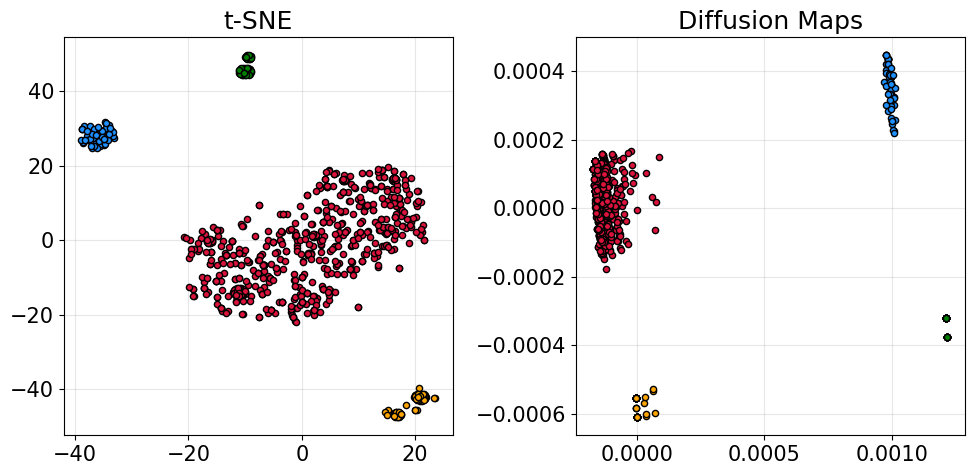

In [327]:
tsne_labels_2 = []
for i, row in enumerate(dm_coords):
    if row[1] < -0.0004:
        tsne_labels_2.append(0)
    elif row[1] < -0.0002:
        tsne_labels_2.append(1)
    elif row[1] < 0.0002:
        tsne_labels_2.append(2)
    else:
        tsne_labels_2.append(3)
    
fig, axs = plt.subplots(1, 2, figsize=(10,5))

colors = ["orange", "green", "crimson", "dodgerblue"]
titles = ["t-SNE", "Diffusion Maps"]

for j, coords in enumerate([tsne_coords, dm_coords]):
    for i, row in enumerate(coords):
        axs[j].scatter(row[0], row[1], color=colors[tsne_labels_2[i]], edgecolor='k', s=20)
    axs[j].set_title(titles[j])
    
    

fig.tight_layout()

plt.savefig("tsne_dm_bccas.pdf", bbox_inches="tight")

plt.show()

In [331]:
feats

['r2_15_2',
 'r2_23',
 'r3_02_1',
 'r2_18',
 'r2_17',
 'r3_07_1',
 'r3_03_2',
 'r2_15_3',
 'r3_03_1',
 'r3_06_1',
 'r2_22',
 'r2_15_6',
 'r2_15_4',
 'r2_20',
 'r2_15_1',
 'r2_19',
 'r2_21',
 'r2_15_5',
 'r3_05_1',
 'r3_04_1']

In [352]:
grouped = {i:[] for i in range(4)}

f = "r3_02_1"

for i, l in enumerate(tsne_labels_2):
    grouped[l].append(DATA.iloc[i][f])

In [339]:
asdf = []
for index, row in DATA.iterrows():
    if -1 in list(row):
        continue
    else:
        asdf.append(row)

In [341]:
len(asdf)

256

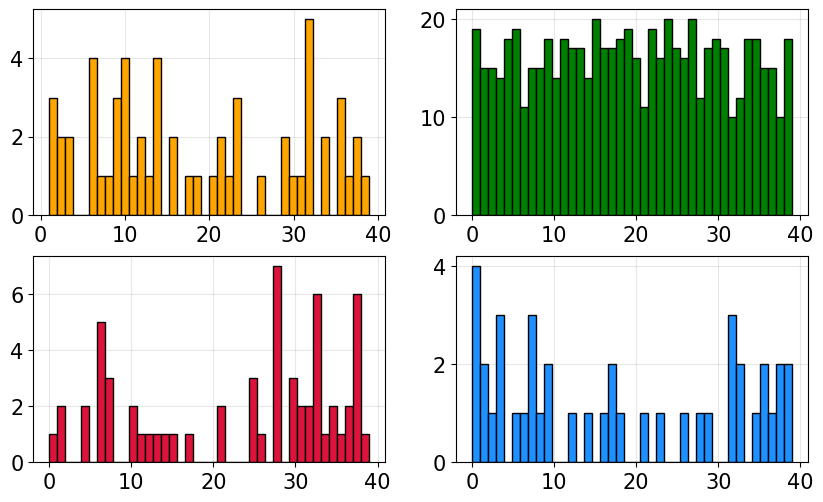

In [95]:
composition = {i:[] for i in range(4)}
for i, label in enumerate(tsne_labels):
    composition[label].append(DATA.iloc[i]["community_code"])


fig, axs = plt.subplots(2, 2, figsize=(10,6))

j = k = 0
for i, c in enumerate(composition):
    axs[k][j].hist(composition[i], color=colors[i], edgecolor="k", bins=40)
    j += 1
    if j == 2:
        j = 0
        k += 1